In [1]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from collections import Counter

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91638\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91638\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
train_data = pd.read_csv('train_product_data.csv')
print(train_data)

                                uniq_id            crawl_timestamp  \
0      c2d766ca982eca8304150849735ffef9  2016-03-25 22:59:23 +0000   
1      f449ec65dcbc041b6ae5e6a32717d01b  2016-03-25 22:59:23 +0000   
2      0973b37acd0c664e3de26e97e5571454  2016-03-25 22:59:23 +0000   
3      ce5a6818f7707e2cb61fdcdbba61f5ad  2016-03-25 22:59:23 +0000   
4      29c8d290caa451f97b1c32df64477a2c  2016-03-25 22:59:23 +0000   
...                                 ...                        ...   
14994  abda697c6da997f66c78d91d6c88078c  2015-12-20 08:26:17 +0000   
14995  87bcdd46bb48bfc1045d7ee84aef7b7a  2015-12-20 08:26:17 +0000   
14996  b4fad612a9f72f1ffd10134f9be7cfe8  2015-12-20 08:26:17 +0000   
14997  1336909e5468b63c9b1281350eba647d  2015-12-20 08:26:17 +0000   
14998  d6eff0e0c938cc39c4451083994a2227  2015-12-20 08:26:17 +0000   

                                             product_url  \
0      http://www.flipkart.com/alisha-solid-women-s-c...   
1      http://www.flipkart.com/aw-belli

# 1.Data Exploration and Prepration

In [3]:
# Display basic information and first few rows
print("Dataset Information:")
print(train_data.info())
print("\nFirst few rows of the dataset:")
print(train_data.head())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  14999 non-null  object 
 1   crawl_timestamp          14999 non-null  object 
 2   product_url              14999 non-null  object 
 3   product_name             14999 non-null  object 
 4   product_category_tree    14999 non-null  object 
 5   pid                      14999 non-null  object 
 6   retail_price             14942 non-null  float64
 7   discounted_price         14942 non-null  float64
 8   image                    14996 non-null  object 
 9   is_FK_Advantage_product  14999 non-null  bool   
 10  description              14998 non-null  object 
 11  product_rating           14999 non-null  object 
 12  overall_rating           14999 non-null  object 
 13  brand                    10289 non-null  object 
 14  p

In [4]:
# Check for missing values
print("\nMissing values in each column:")
print(train_data.isnull().sum())



Missing values in each column:
uniq_id                       0
crawl_timestamp               0
product_url                   0
product_name                  0
product_category_tree         0
pid                           0
retail_price                 57
discounted_price             57
image                         3
is_FK_Advantage_product       0
description                   1
product_rating                0
overall_rating                0
brand                      4710
product_specifications        6
dtype: int64


In [5]:
# Dropping rows with missing values in key column
train_data.dropna(subset=['description'], inplace=True)

# 2. Descriptive Analysis

In [6]:
# Unique categories in target
print("\nUnique categories:")
print(train_data['product_category_tree'].unique())


Unique categories:
['Clothing ' 'Footwear ' 'Pens & Stationery ' 'Bags, Wallets & Belts '
 'Home Decor & Festive Needs ' 'Automotive ' 'Tools & Hardware '
 'Baby Care ' 'Mobiles & Accessories ' 'Watches '
 'Toys & School Supplies ' 'Jewellery ' 'Kitchen & Dining ' 'Computers ']


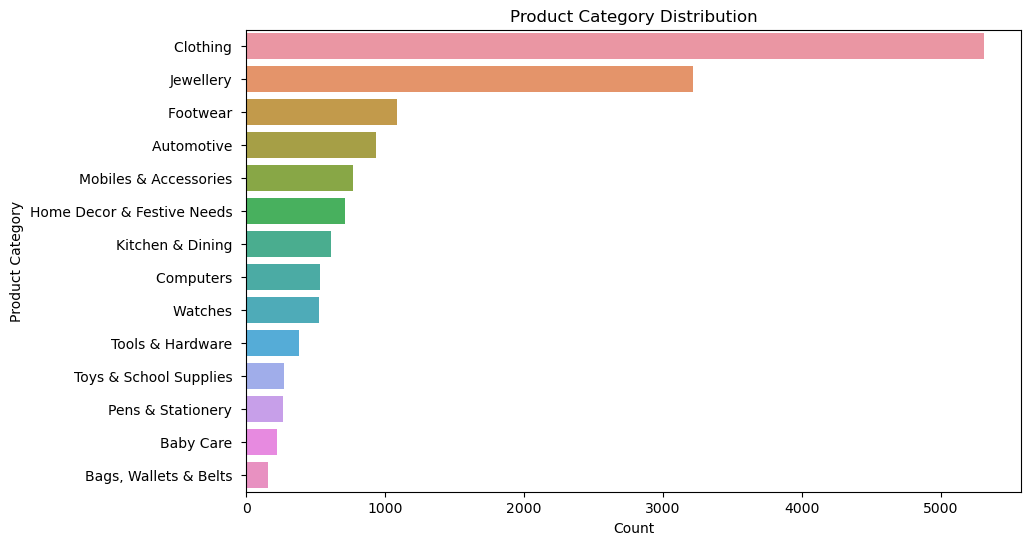

In [7]:
# Analyze target variable distribution
plt.figure(figsize=(10, 6))
sns.countplot(y=train_data['product_category_tree'], order=train_data['product_category_tree'].value_counts().index)
plt.title("Product Category Distribution")
plt.xlabel("Count")
plt.ylabel("Product Category")
plt.show()

In [8]:
# Statistical summary for numerical columns
print("\nStatistical Summary:")
print(train_data.describe())


Statistical Summary:
        retail_price  discounted_price
count   14941.000000      14941.000000
mean     3128.547085       2087.828860
std      9154.757355       7712.496939
min        35.000000         35.000000
25%       699.000000        349.000000
50%      1000.000000        499.000000
75%      1990.000000        999.000000
max    571230.000000     571230.000000


# 3. Feature engineering/Text to features

In [9]:
def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    # Removing special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenization and removing stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [10]:
# Apply preprocessing to the description
train_data['cleaned_description'] = train_data['description'].apply(preprocess_text)

In [11]:
# First, calculate the length of each description
train_data['description_length'] = train_data['cleaned_description'].apply(len)

# Calculate the mean length
mean_description_length = train_data['description_length'].max()
mean_description_length

3798

In [12]:
# Encode Target Variable
label_encoder = LabelEncoder()
train_data['category_encoded'] = label_encoder.fit_transform(train_data['product_category_tree'])

In [13]:
# Convert text descriptions to numerical features using TF-IDF
tfidf = TfidfVectorizer(max_features=4000, stop_words='english') 
X = tfidf.fit_transform(train_data['cleaned_description']).toarray()
y = train_data['category_encoded']

In [14]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [43]:
# Check class distribution in target
print("\nClass distribution before handling imbalance:", Counter(y_train))



Class distribution before handling imbalance: Counter({3: 4252, 7: 2574, 5: 866, 0: 750, 9: 614, 6: 571, 8: 488, 4: 425, 13: 421, 11: 303, 12: 217, 10: 211, 1: 179, 2: 127})


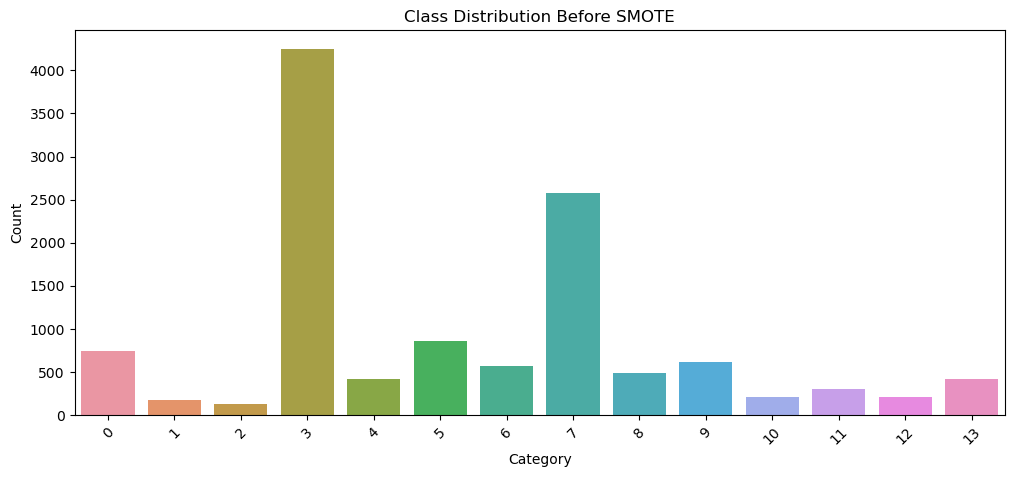

In [46]:
def plot_class_distribution(y, title):
    class_distribution = Counter(y)
    class_distribution_df = pd.DataFrame(class_distribution.items(), columns=['Category', 'Count'])
    
    plt.figure(figsize=(12, 5))
    sns.barplot(x='Category', y='Count', data=class_distribution_df)
    plt.title(title)
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()
    
plot_class_distribution(y_train, 'Class Distribution Before SMOTE')

In [16]:
# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [17]:
# Check class distribution after SMOTE
print("\nClass distribution after handling imbalance:", Counter(y_train_res))


Class distribution after handling imbalance: Counter({3: 4252, 4: 4252, 6: 4252, 7: 4252, 0: 4252, 9: 4252, 11: 4252, 8: 4252, 1: 4252, 5: 4252, 12: 4252, 13: 4252, 10: 4252, 2: 4252})


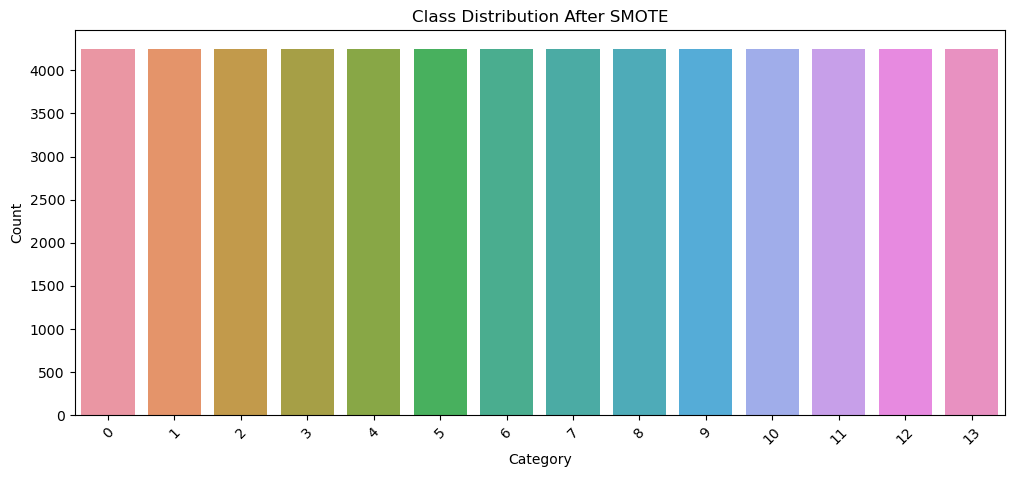

In [47]:
# Plot after SMOTE
plot_class_distribution(y_train_res, 'Class Distribution After SMOTE')

In [18]:
# 4. Cross-Validation Setup
# Using StratifiedKFold for consistent splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [19]:
# Model with Cross-Validation for RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)
rf_cv_scores = cross_val_score(rf_model, X_train_res, y_train_res, cv=skf, scoring='f1_weighted')

In [23]:
print("\nCross-Validation F1 Scores (Random Forest):", rf_cv_scores)
print("Mean CV F1 Score (Random Forest):", np.mean(rf_cv_scores))


Cross-Validation F1 Scores (Random Forest): [0.99655591 0.99705892 0.99672385 0.99605088 0.99596818]
Mean CV F1 Score (Random Forest): 0.9964715471720329


# 4. Predictive Modeling - Multi-Class Text Classifier


In [24]:
# Random Forest Classifier
rf_model.fit(X_train_res, y_train_res)
y_pred_rf = rf_model.predict(X_test)

In [25]:
# Random Forest Evaluation
print("\nRandom Forest Model Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))
print("Accuracy Score (RF):", accuracy_score(y_test, y_pred_rf))
print("F1 Score (RF):", f1_score(y_test, y_pred_rf, average='weighted'))


Random Forest Model Classification Report:
                             precision    recall  f1-score   support

                Automotive        0.99      0.98      0.99       187
                 Baby Care        0.93      0.84      0.88        45
     Bags, Wallets & Belts        0.90      0.84      0.87        31
                  Clothing        0.99      1.00      0.99      1063
                 Computers        0.94      0.93      0.94       106
                  Footwear        0.99      0.96      0.98       217
Home Decor & Festive Needs        0.96      0.98      0.97       143
                 Jewellery        1.00      1.00      1.00       644
          Kitchen & Dining        0.94      0.98      0.96       122
     Mobiles & Accessories        0.96      0.99      0.98       154
         Pens & Stationery        0.93      0.72      0.81        53
          Tools & Hardware        0.99      0.96      0.97        76
    Toys & School Supplies        0.83      0.93      0.88

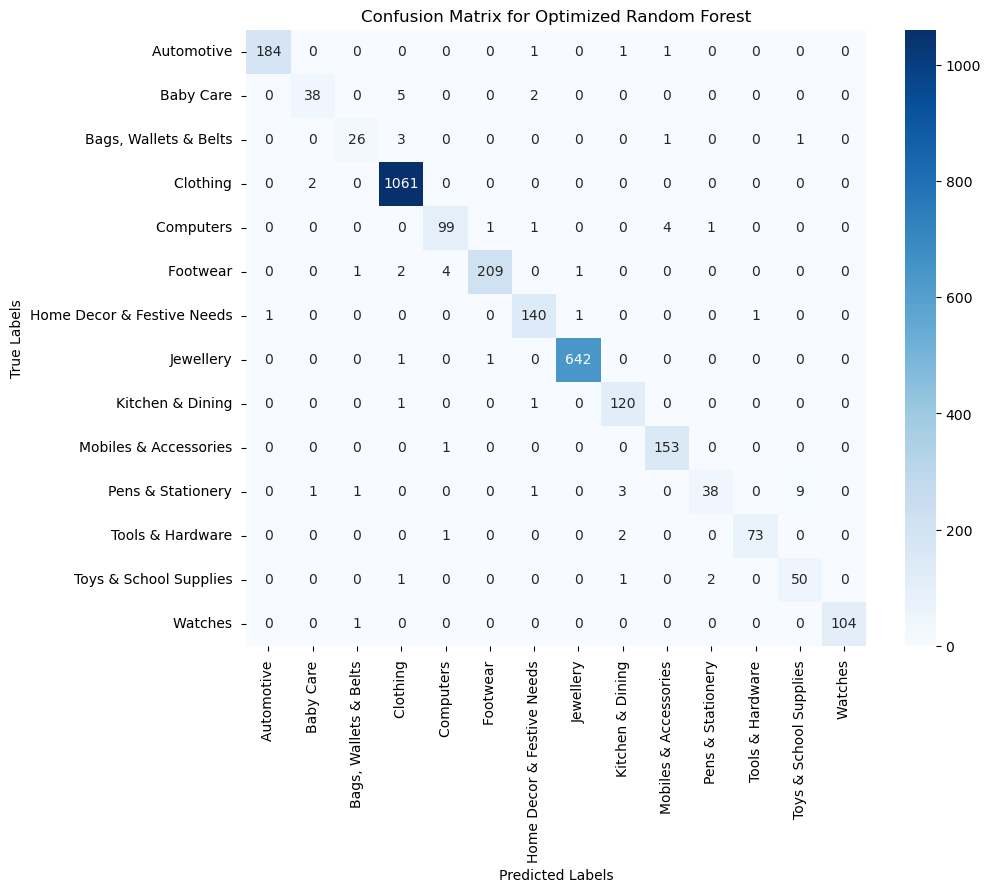

In [26]:
# Confusion Matrix for Optimized Model
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix for Optimized Random Forest")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [27]:
# Naive Bayes Classifier
nb_model = MultinomialNB()
nb_model.fit(X_train_res, y_train_res)
y_pred_nb = nb_model.predict(X_test)

In [28]:
# Naive Bayes Evaluation
print("\nNaive Bayes Model Classification Report:")
print(classification_report(y_test, y_pred_nb, target_names=label_encoder.classes_))
print("Accuracy Score (NB):", accuracy_score(y_test, y_pred_nb))
print("F1 Score (NB):", f1_score(y_test, y_pred_nb, average='weighted'))



Naive Bayes Model Classification Report:
                             precision    recall  f1-score   support

                Automotive        0.99      0.97      0.98       187
                 Baby Care        0.38      0.84      0.52        45
     Bags, Wallets & Belts        0.88      0.94      0.91        31
                  Clothing        1.00      0.94      0.97      1063
                 Computers        0.88      0.84      0.86       106
                  Footwear        0.99      1.00      0.99       217
Home Decor & Festive Needs        0.94      0.99      0.96       143
                 Jewellery        1.00      1.00      1.00       644
          Kitchen & Dining        0.95      0.93      0.94       122
     Mobiles & Accessories        0.96      0.95      0.95       154
         Pens & Stationery        0.89      0.60      0.72        53
          Tools & Hardware        0.99      0.96      0.97        76
    Toys & School Supplies        0.61      0.94      0.74  

# Discuss Model Strengths and Weaknesses
Model Suitability Analysis:
Random Forest tends to perform better with structured and feature-rich data, often capturing complex patterns well.
Naive Bayes, with its simple probabilistic approach, is often suitable for text classification but may struggle with complex feature interactions.
 Here, Random Forest achieves higher F1 scores, suggesting its better suitability for this multiclass problem with categorical distribution.


In [29]:
#Predictive Modeling - Multi-Class Text Classifier
# Logistic Regression Model
lr_model = LogisticRegression(max_iter=200)
lr_model.fit(X_train_res, y_train_res)

# Predictions
y_pred_lr = lr_model.predict(X_test)

# Model Evaluation
print("\nLogistic Regression Model Classification Report:")
print(classification_report(y_test, y_pred_lr, target_names=label_encoder.classes_))
print("Accuracy Score:", accuracy_score(y_test, y_pred_lr))
print("F1 Score:", f1_score(y_test, y_pred_lr, average='weighted'))


Logistic Regression Model Classification Report:
                             precision    recall  f1-score   support

                Automotive        0.99      0.97      0.98       187
                 Baby Care        0.84      0.91      0.87        45
     Bags, Wallets & Belts        0.88      0.94      0.91        31
                  Clothing        1.00      0.99      0.99      1063
                 Computers        0.98      0.98      0.98       106
                  Footwear        1.00      0.99      0.99       217
Home Decor & Festive Needs        0.96      0.99      0.97       143
                 Jewellery        1.00      1.00      1.00       644
          Kitchen & Dining        0.95      0.98      0.97       122
     Mobiles & Accessories        0.98      0.98      0.98       154
         Pens & Stationery        0.87      0.62      0.73        53
          Tools & Hardware        1.00      0.97      0.99        76
    Toys & School Supplies        0.74      0.91    

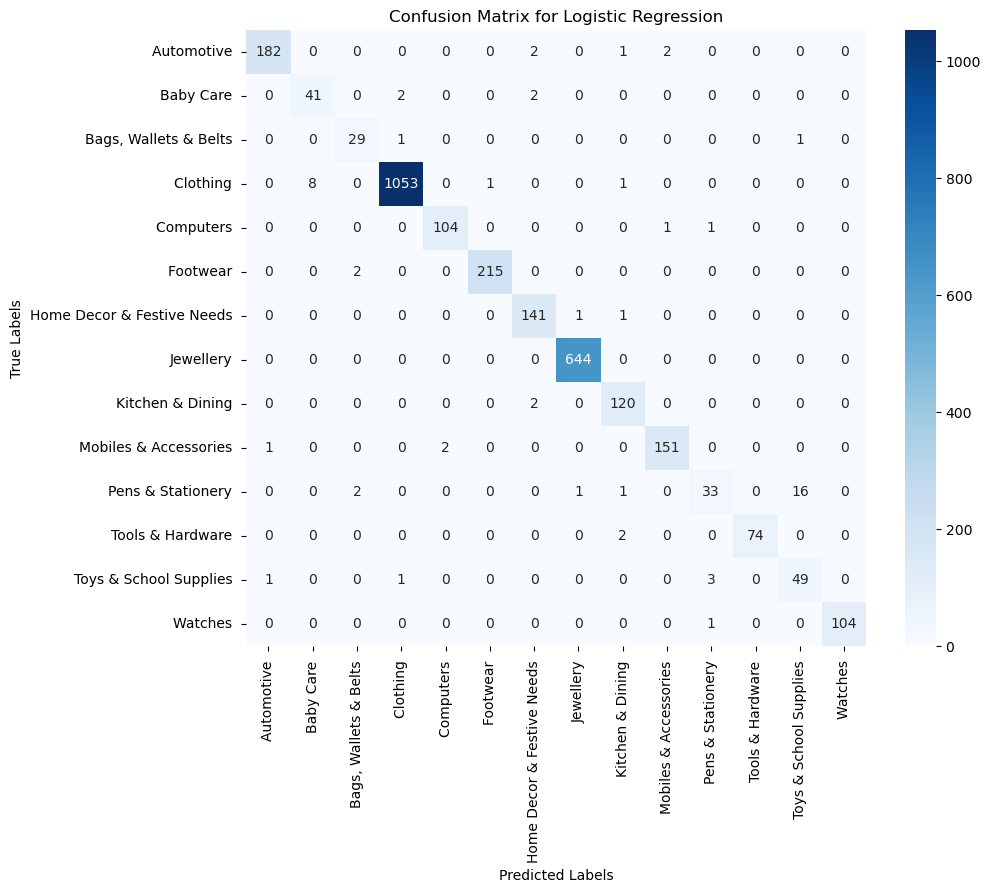

In [30]:
# Confusion Matrix Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix for Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [32]:
print('RandomForest - 97.86%')
print('MNB - 95.67%')
print('LogisticRegression - 97.98%')

RandomForest - 97.86%
MNB - 95.67%
LogisticRegression - 97.98%


Let's go with Logistic reggression as it has the highest accuracy among the other models

# 5.Lets pridict the Category of unseen data

In [33]:
# Load the test data
test_data = pd.read_csv('test_data.csv')

In [37]:
test_data.head()

,uniq_id,crawl_timestamp,product_url,product_name,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,cleaned_description
0,4fb99d98225f415e7ece96938e95628f,2015-12-20 08:26:17 +0000,http://www.flipkart.com/v-v-art-brass-bracelet...,V&V ART Brass Bracelet,BBAE6NYHCDTEZJTB,470.0,423.0,"[""http://img6a.flixcart.com/image/bangle-brace...",False,V&V ART Brass Bracelet - Buy V&V ART Brass Bra...,No rating available,No rating available,V&V ART,"{""product_specification""=>[{""key""=>""Brand"", ""v...",vv art brass bracelet buy vv art brass bracele...
1,4ea284c8d38b2ea97a1c2a26f34e057c,2015-12-20 08:26:17 +0000,http://www.flipkart.com/kalpaveda-copper-cuff/...,Kalpaveda Copper Copper Cuff,BBAEDFFKZJTY7SZZ,1200.0,1200.0,"[""http://img6a.flixcart.com/image/bangle-brace...",False,Kalpaveda Copper Copper Cuff\n ...,No rating available,No rating available,Kalpaveda,"{""product_specification""=>[{""key""=>""Stretchabl...",kalpaveda copper copper cuff price rs attract ...
2,ee6ce2c7045c54257e2a0b590e09c296,2015-12-20 08:26:17 +0000,http://www.flipkart.com/thelostpuppy-book-cove...,Thelostpuppy Book Cover for Apple iPad Air,ACCEA4DZH6M5SFVH,2199.0,599.0,"[""http://img5a.flixcart.com/image/cases-covers...",False,Thelostpuppy Book Cover for Apple iPad Air (Mu...,No rating available,No rating available,Thelostpuppy,"{""product_specification""=>[{""key""=>""Brand"", ""v...",thelostpuppy book cover apple ipad air multico...
3,e797ba3b5f2e2d1fdc520e48486ab60e,2015-12-20 08:26:17 +0000,http://www.flipkart.com/riana-copper-bangle/p/...,Riana Copper Copper Bangle,BBAEAXFQHHMF3EYZ,2499.0,649.0,"[""http://img5a.flixcart.com/image/bangle-brace...",False,Riana Copper Copper Bangle - Buy Riana Copper ...,5,5,Riana,"{""product_specification""=>[{""key""=>""Collection...",riana copper copper bangle buy riana copper co...
4,f4d8d43858c8858c68d75ce07ac641c0,2015-12-20 08:26:17 +0000,http://www.flipkart.com/inox-jewelry-stainless...,Inox Jewelry Stainless Steel Cuff,BBAECH63WYDG6TE2,1629.0,1222.0,"[""http://img6a.flixcart.com/image/bangle-brace...",False,Inox Jewelry Stainless Steel Cuff\n ...,No rating available,No rating available,Inox Jewelry,"{""product_specification""=>[{""key""=>""Stretchabl...",inox jewelry stainless steel cuff price rs ino...


In [34]:
#Data Preprocessing on Test Data
# Function to preprocess the text
def preprocess_text(text):
    text = text.lower()  # Lowercasing
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    tokens = text.split()  # Tokenization
    tokens = [word for word in tokens if word not in stop_words]  # Remove stop words
    return ' '.join(tokens)

In [35]:
# Applying preprocessing
test_data['cleaned_description'] = test_data['description'].apply(preprocess_text)


In [36]:
# Vectorization using the same TF-IDF vectorizer
X_test_final = tfidf.transform(test_data['cleaned_description']).toarray()


In [41]:
# Predicting using the trained model (Logistic Regression)
predictions = lr_model.predict(X_test_final)
predicted_product_category_tree = label_encoder.inverse_transform(predictions)


In [42]:
results = pd.DataFrame({'predicted_product_category_tree': predicted_product_category_tree})

# Save the predictions to a CSV file
results.to_csv('predictions.csv', index=False)
print("Predictions saved to 'predictions.csv'.")

Predictions saved to 'predictions.csv'.
